# NOTEBOOK FOR THE ANALYSIS OF SINGLE-CELL RNA-SEQUENCING DATA FROM LFSMB1R

In [17]:
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import scrublet as scr
import pandas as pd
from matplotlib import rcParams

In [18]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [19]:
results_file = '/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/scanpy/ST1R-PDX_scanpy.h5ad'  # the file that will store the analysis results

## READ IN THE DATA FOR LFSMB1R-PDX AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [20]:
adata_st1r = sc.read_10x_mtx(
    '/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/data/10XRNA5P/LFSMB1R/LFSMB1R-PDX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata_st1r.var_names_make_unique()
adata_st1r

# make some metadata
adata_lfsmb1r.obs['sample'] = "LFSMB1R"
adata_lfsmb1r.obs['technology'] = "PDX"
adata_lfsmb1r.obs['patient'] = "LFSMB"

... reading from cache file cache/icgc-dkfzlsdf-analysis-B260-projects-chromothripsis_medulloblastoma-data-10XRNA5P-ST1R-ST1R-PDX-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [21]:
adata_lfsmb1r

AnnData object with n_obs × n_vars = 2207 × 32738
    obs: 'sample', 'technology', 'patient'
    var: 'gene_ids', 'feature_types'

In [22]:
lfsmb1r_mouse_cells = pd.read_csv("/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/data/10XRNA5P/LFSMB1R/mm10_and_hg19/sample4.mapping.counts.txt", sep = '\t')
lfsmb1r_mouse_cells

,cell,count.hg19,count.mm10,total.count,ratio
0,AAACCTGAGTACATGA-1,3240,6,3246,540.000000
1,AAACCTGCAAGCCCAC-1,3089,2,3091,1544.500000
2,AAACCTGCAGCCAATT-1,5127,10,5137,512.700000
3,AAACGGGAGCGAGAAA-1,3671,9,3680,407.888889
4,AAACGGGCAGATAATG-1,587,1,588,587.000000
...,...,...,...,...,...
2224,TTTGGTTGTTACGTCA-1,1533,6,1539,255.500000
2225,TTTGGTTTCAAACAAG-1,8978,7,8985,1282.571429
2226,TTTGTCAAGTCCCACG-1,1489,3,1492,496.333333
2227,TTTGTCACAATGCCAT-1,3210,5,3215,642.000000


In [23]:
lfsmb1r_mouse_cells = lfsmb1r_mouse_cells[lfsmb1r_mouse_cells['ratio'] > 1]
lfsmb1r_mouse_cells

,cell,count.hg19,count.mm10,total.count,ratio
0,AAACCTGAGTACATGA-1,3240,6,3246,540.000000
1,AAACCTGCAAGCCCAC-1,3089,2,3091,1544.500000
2,AAACCTGCAGCCAATT-1,5127,10,5137,512.700000
3,AAACGGGAGCGAGAAA-1,3671,9,3680,407.888889
4,AAACGGGCAGATAATG-1,587,1,588,587.000000
...,...,...,...,...,...
2224,TTTGGTTGTTACGTCA-1,1533,6,1539,255.500000
2225,TTTGGTTTCAAACAAG-1,8978,7,8985,1282.571429
2226,TTTGTCAAGTCCCACG-1,1489,3,1492,496.333333
2227,TTTGTCACAATGCCAT-1,3210,5,3215,642.000000


In [24]:
lfsmb1r_mouse_cells_barcodes = lfsmb1r_mouse_cells['cell']
lfsmb1r_mouse_cells_barcodes 

0       AAACCTGAGTACATGA-1
1       AAACCTGCAAGCCCAC-1
2       AAACCTGCAGCCAATT-1
3       AAACGGGAGCGAGAAA-1
4       AAACGGGCAGATAATG-1
               ...        
2224    TTTGGTTGTTACGTCA-1
2225    TTTGGTTTCAAACAAG-1
2226    TTTGTCAAGTCCCACG-1
2227    TTTGTCACAATGCCAT-1
2228    TTTGTCACATAACCTG-1
Name: cell, Length: 2077, dtype: object

In [25]:
adata = adata_lfsmb1r[adata_lfsmb1r.obs_names.isin(lfsmb1r_mouse_cells_barcodes),:]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [26]:
adata.obs

,sample,technology,patient
AAACCTGAGTACATGA-1,ST1R,PDX,ST
AAACCTGCAAGCCCAC-1,ST1R,PDX,ST
AAACCTGCAGCCAATT-1,ST1R,PDX,ST
AAACGGGAGCGAGAAA-1,ST1R,PDX,ST
AAACGGGCAGATAATG-1,ST1R,PDX,ST
...,...,...,...
TTTGGTTGTTACGTCA-1,ST1R,PDX,ST
TTTGGTTTCAAACAAG-1,ST1R,PDX,ST
TTTGTCAAGTCCCACG-1,ST1R,PDX,ST
TTTGTCACAATGCCAT-1,ST1R,PDX,ST


In [27]:
scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.06)

In [28]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 0.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 30.3%
Elapsed time: 1.7 seconds


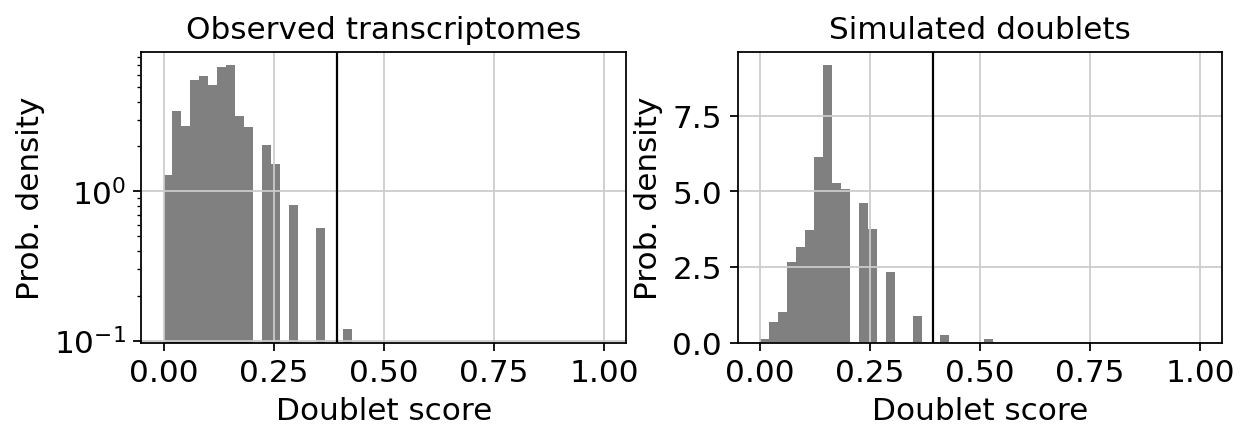

In [29]:
scrub.plot_histogram();

## START PERFORMING THE INITIAL QUALITY CONTROL

normalizing counts per cell
    finished (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


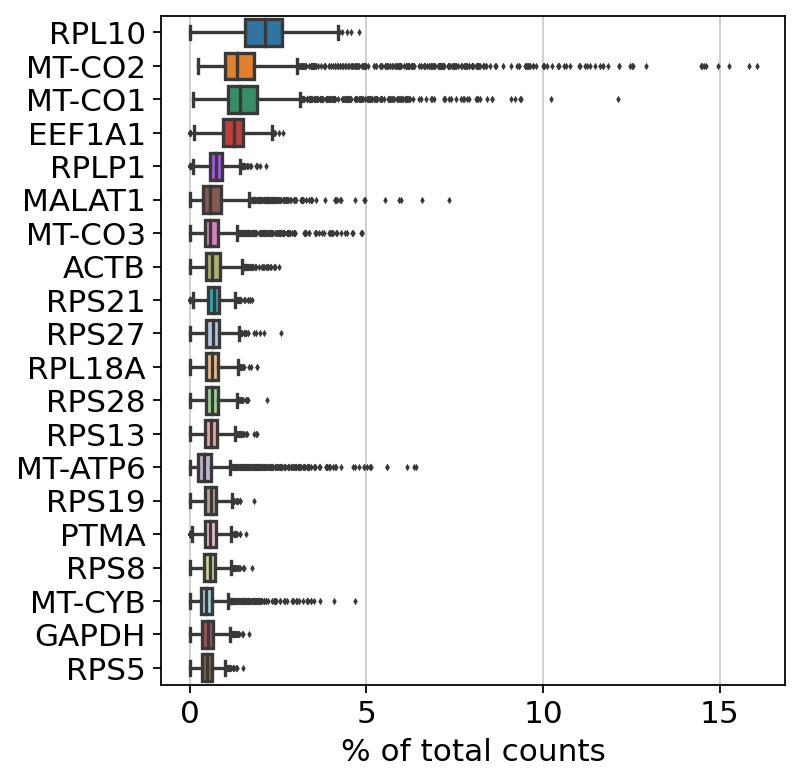

In [30]:
# preprocessing
sc.pl.highest_expr_genes(adata, n_top=20,)

In [31]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 17419 genes that are detected in less than 3 cells


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [32]:
# calculate some quality metrics as for instance mitochondrial percentage
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# and for ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'patient' as categorical
... storing 'feature_types' as categorical


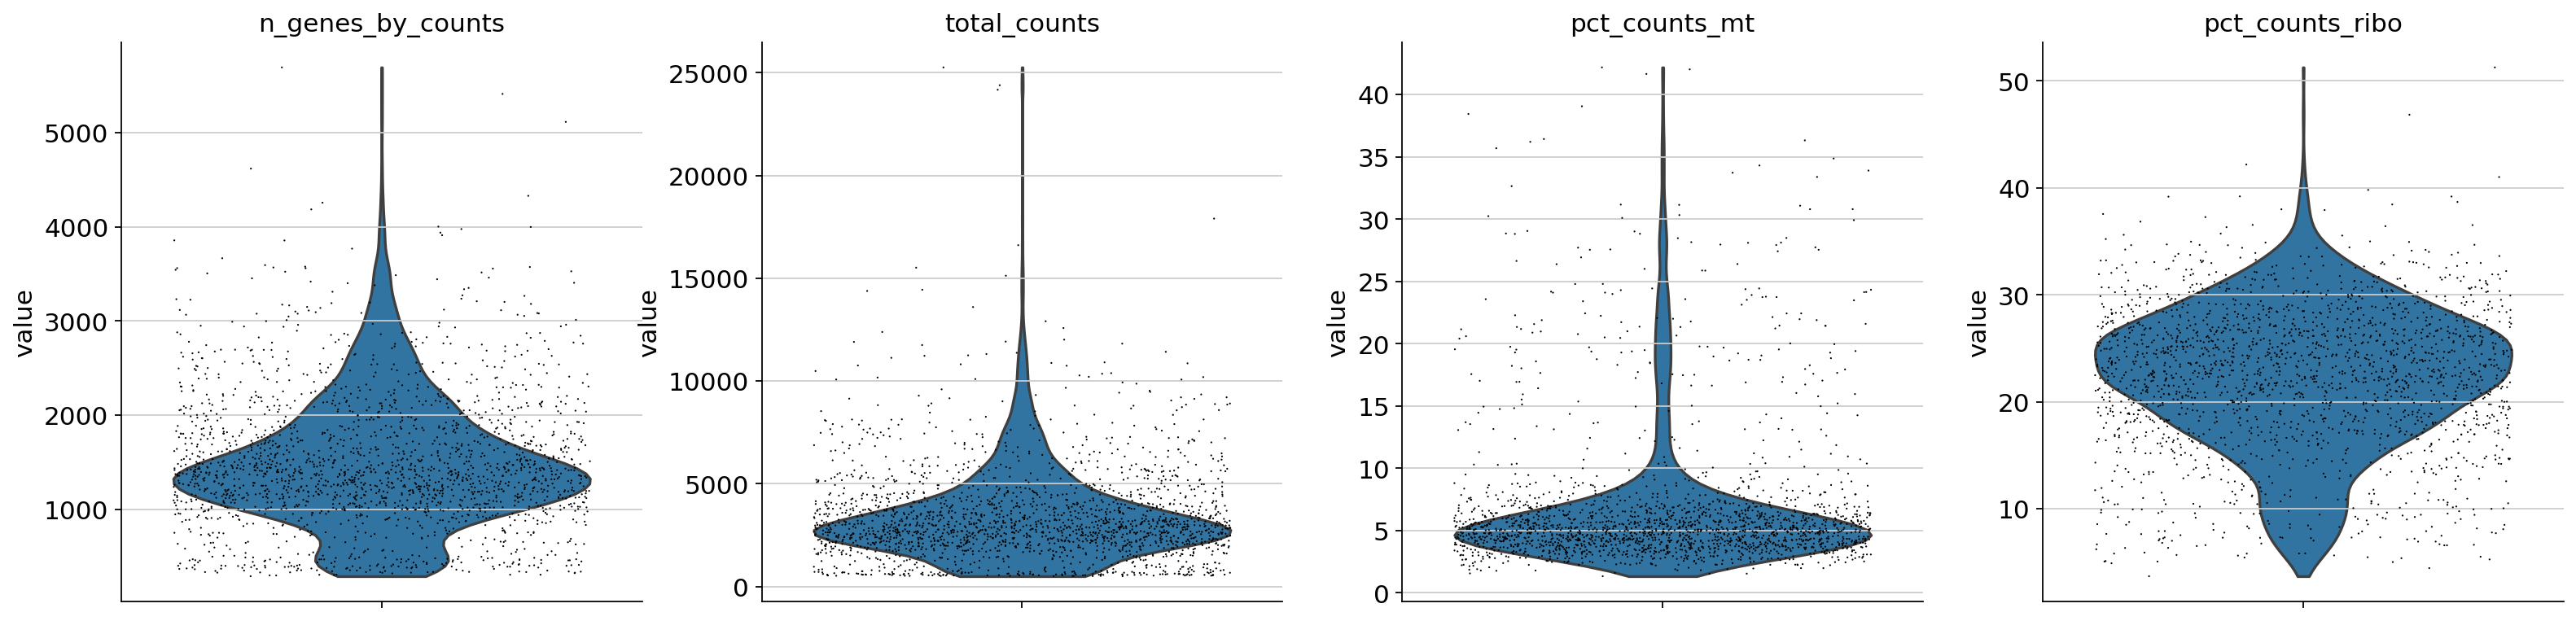

In [33]:
# visualize some QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

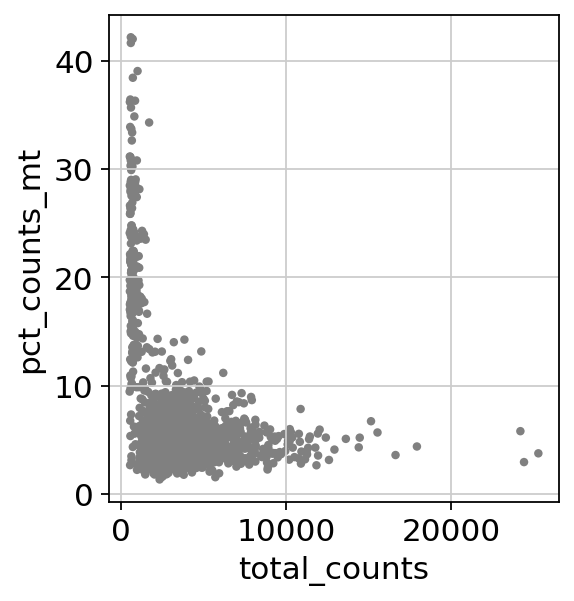

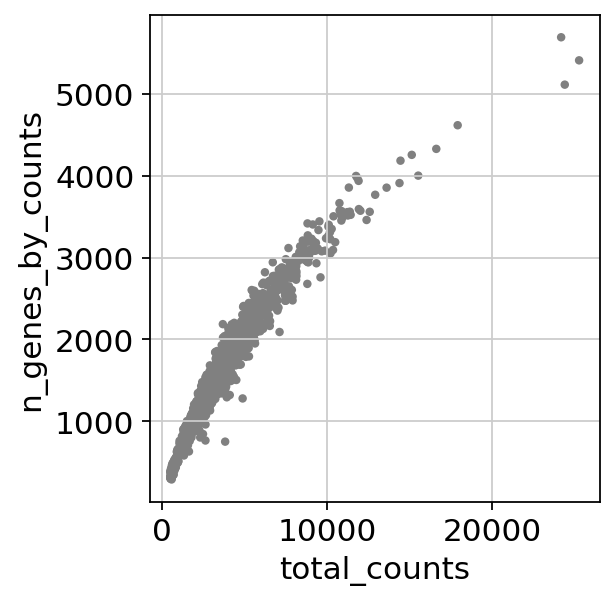

In [34]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [35]:
# do the actual filtering by slicing the object
adata = adata[200 < adata.obs.n_genes_by_counts, :]
adata = adata[500 < adata.obs.total_counts, :]
adata = adata[adata.obs.total_counts < 25000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata = adata[adata.obs.pct_counts_ribo < 40, :]

/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [36]:
adata

View of AnnData object with n_obs × n_vars = 1817 × 15319
    obs: 'sample', 'technology', 'patient', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'

In [37]:
# calculate mean number of genes detected
mean_genes = adata.obs['n_genes'].mean()
print(mean_genes)

# calculate mean number of transcripts detected
mean_counts = adata.obs['total_counts'].mean()
print(mean_counts)

1611.298293891029
3709.231201171875


## PERFORM NORMALIZATION, PCA AND CLUSTERING

In [38]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [39]:
sc.pp.log1p(adata)

In [40]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


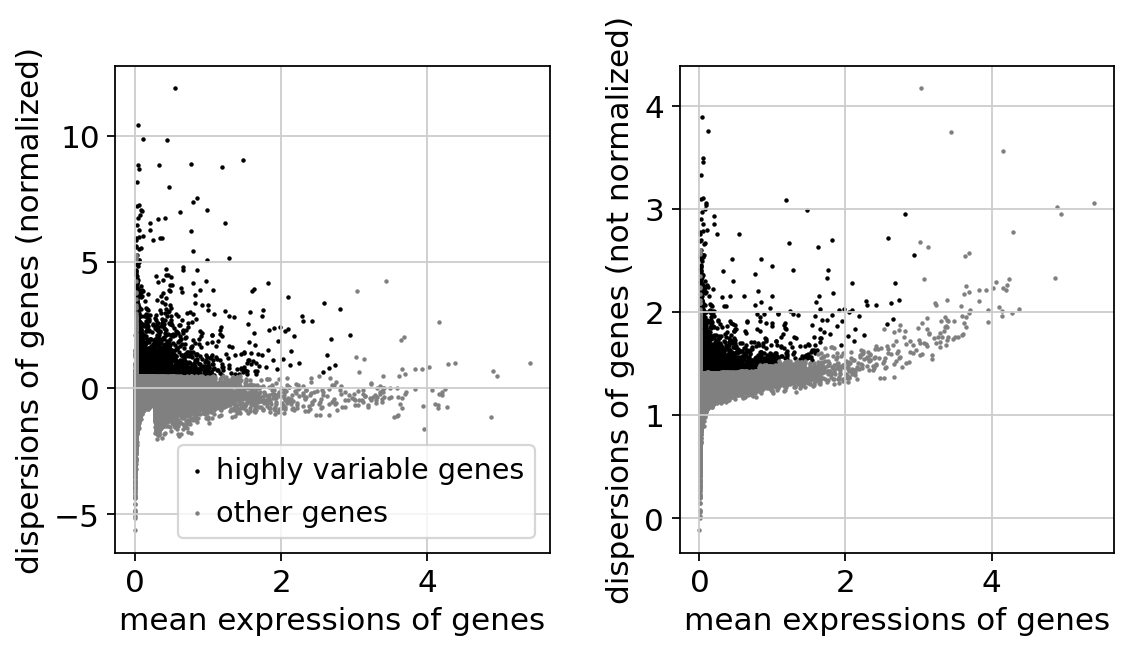

In [41]:
sc.pl.highly_variable_genes(adata)

In [42]:
# set the raw attribute of anndata
adata.raw = adata

In [43]:
adata = adata[:, adata.var.highly_variable]

In [44]:
# regress out effects of total counts per cell and the percentage of mitochondrial genes
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

regressing out ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)


In [45]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


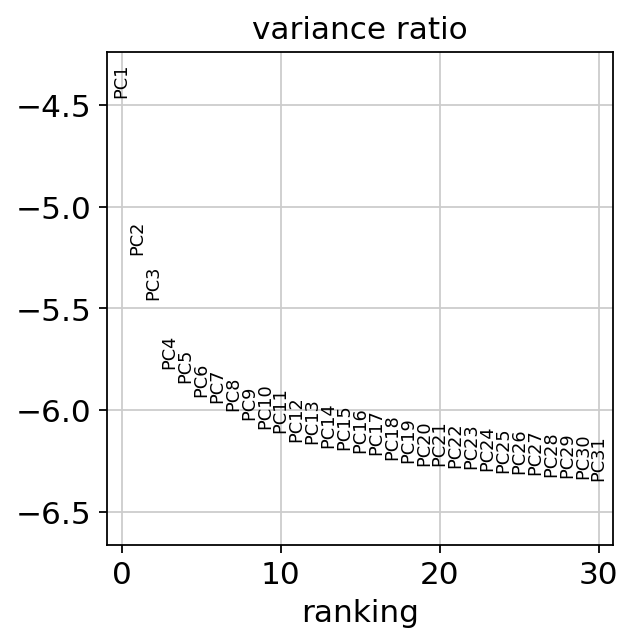

In [46]:
sc.pl.pca_variance_ratio(adata, log=True)

In [47]:
# compute nearest neighbors, UMAP and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=4)
sc.tl.umap(adata, n_components=2, min_dist=0.1,  # Scanpy default = 0.05
           spread=1.0, copy=False, random_state=0)
sc.tl.louvain(adata, resolution= 0.2)
sc.tl.leiden(adata, resolution= 0.2)

computing neighbors
    using 'X_pca' with n_pcs = 4
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


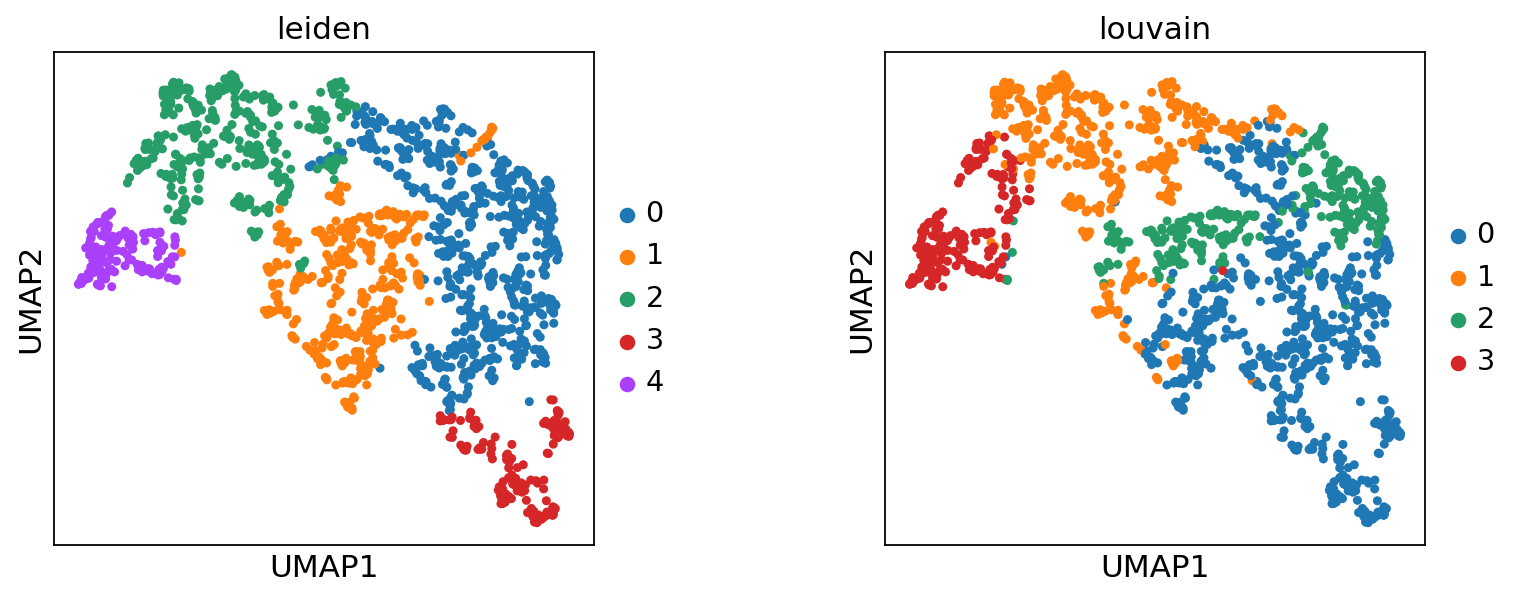

In [48]:
sc.pl.umap(adata, color=['leiden', 'louvain'], save = '_ST1R-PDX.pdf', wspace = 0.4)

ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


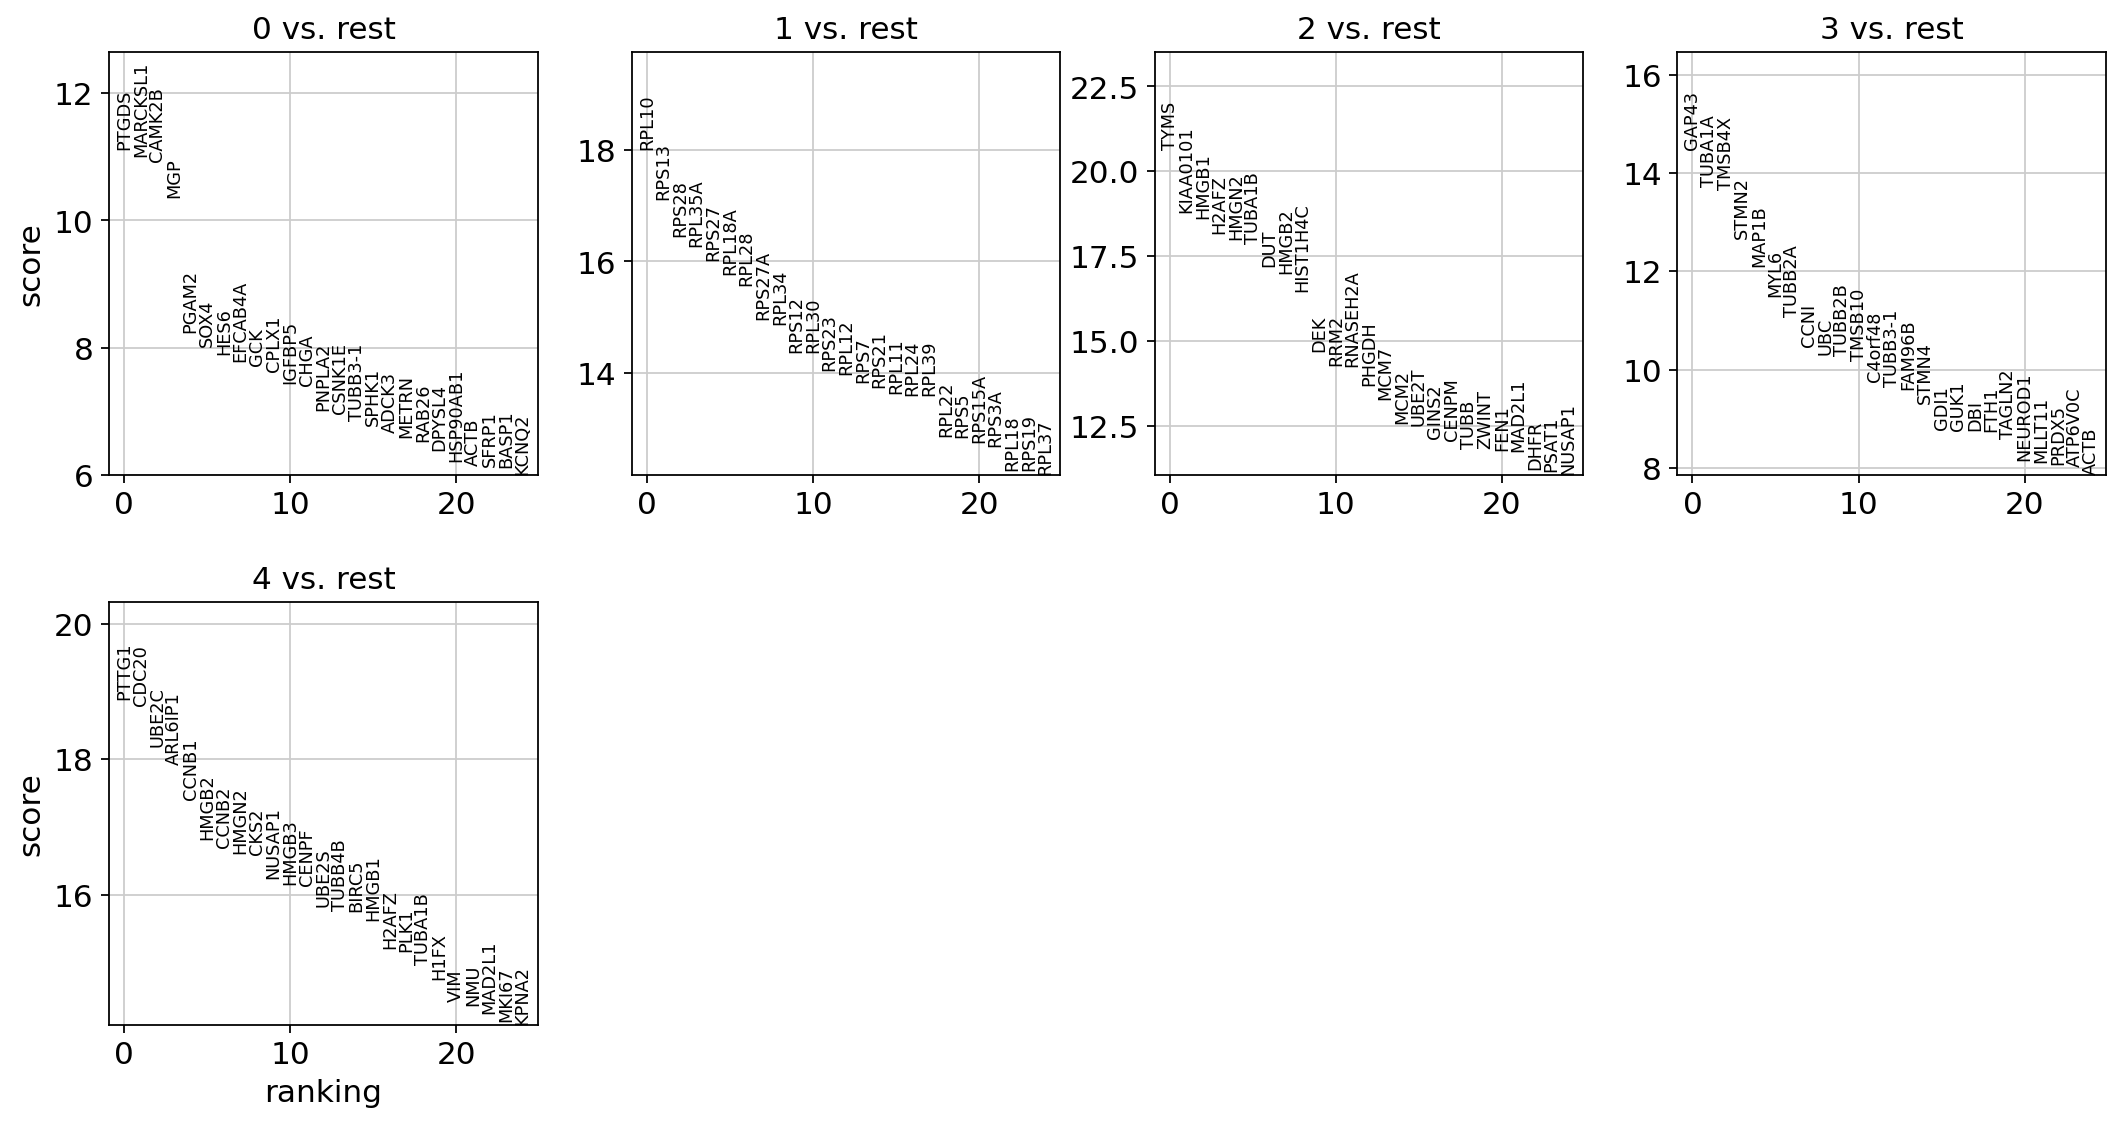

In [49]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save = "_ST1R-PDX_leiden.pdf")

In [50]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4
0,PTGDS,RPL10,TYMS,GAP43,PTTG1
1,MARCKSL1,RPS13,KIAA0101,TUBA1A,CDC20
2,CAMK2B,RPS28,HMGB1,TMSB4X,UBE2C
3,MGP,RPL35A,H2AFZ,STMN2,ARL6IP1
4,PGAM2,RPS27,HMGN2,MAP1B,CCNB1


In [51]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', "scores", 'logfoldchanges', "pvals", 'pvals_adj']})

In [52]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/ST1R-PDX_DEG_wilcoxon.csv")

In [53]:
new_cluster_names = ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4']
adata.rename_categories('leiden', new_cluster_names)

old_to_new = dict(
    cluster0='malignant SHH',
    cluster1='malignant basal state',
    cluster2='malignant cycling I',
    cluster3='malignant development',
    cluster4='malignant cycling II'
)

adata.obs['new_clusters'] = (
    adata.obs['leiden']
    .map(old_to_new)
    .astype('category')
)

/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


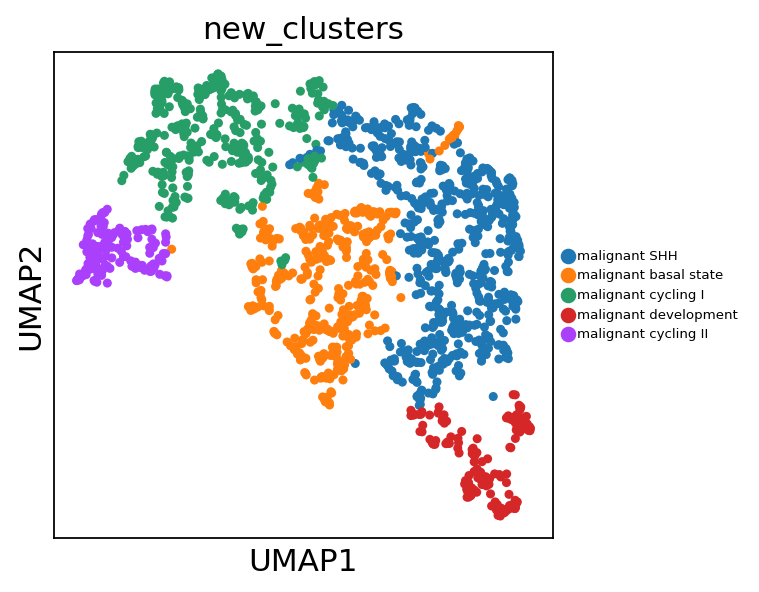

In [54]:
sc.pl.umap(adata, color=['new_clusters'], save = '_ST1R-PDX_CellType.pdf', wspace = 0.6, legend_fontsize = 6)

In [55]:
adata.write("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/ST1R-PDX_Aurelie_Celltype_scanpy.h5ad")

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [56]:
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/ST1R-PDX_metadata.csv')

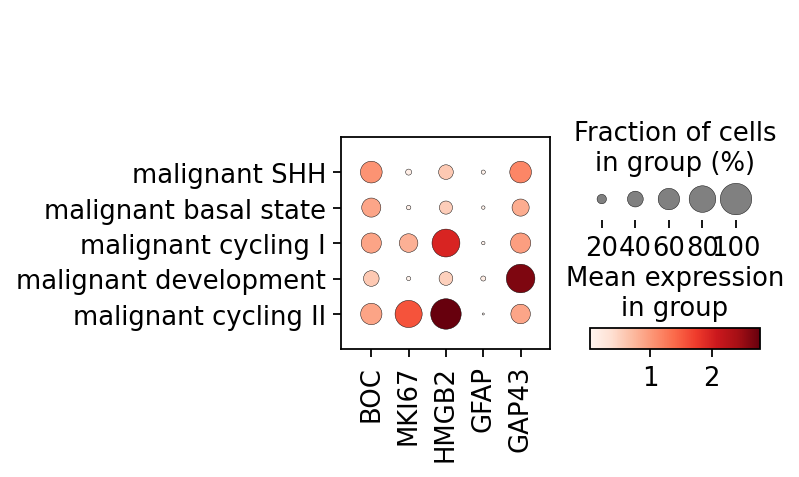

In [57]:
aurelie_marker_genes = ["BOC", "MKI67", "HMGB2", "GFAP", "GAP43"]

sc.pl.dotplot(adata, aurelie_marker_genes, groupby='new_clusters')

## PROJECT ALIGNED SCDNA CLONES ONTO THE EMBEDDING

In [24]:
adata = sc.read("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/ST1R-PDX_Aurelie_Celltype_scanpy.h5ad")

In [58]:
scDNA_clones = pd.read_csv("/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/ST1R-PDX/ST1R-PDX_scDNA_clones_filtered_cells.txt", sep = '\t', index_col=0)
scDNA_clones

,clone_id,pearson.correlation,Clone1,Clone2,Clone1_pval,Clone2_pval,num_pval_clones,min_pval,padj
Cell_barcode,,,,,,,,,
CGGACTGAGTGCAAGC-1,Clone2,0.100802,-0.129243,-0.100802,0.966,0.865,0,0.865,1.730
GGGAATGGTCACAAGG-1,Clone2,0.165911,-0.212723,-0.165911,1.000,0.973,0,0.973,1.946
AACACGTAGCGCCTCA-1,Clone1,0.179799,-0.179799,-0.362933,0.875,1.001,0,0.875,1.750
TTCTCAAGTGCGATAG-1,Clone1,0.325763,0.325763,0.249801,0.001,0.002,0,0.001,0.002
AACCGCGTCGCGGATC-1,Clone2,0.120564,-0.154580,-0.120564,0.987,0.910,0,0.910,1.820
...,...,...,...,...,...,...,...,...,...
CAAGAAAAGAGGGCTT-1,Clone1,0.449900,0.449900,0.364239,0.001,0.001,2,0.001,0.002
GTGTGCGAGCGTCAAG-1,Clone1,0.383537,0.383537,0.299136,0.001,0.002,0,0.001,0.002
TACGGGCGTCTTGATG-1,Clone1,0.372276,0.372276,0.290353,0.001,0.002,0,0.001,0.002


In [59]:
scDNA_clones = scDNA_clones.loc[scDNA_clones['padj'] <= 0.05, :]
scDNA_clones

,clone_id,pearson.correlation,Clone1,Clone2,Clone1_pval,Clone2_pval,num_pval_clones,min_pval,padj
Cell_barcode,,,,,,,,,
TTCTCAAGTGCGATAG-1,Clone1,0.325763,0.325763,0.249801,0.001,0.002,0,0.001,0.002
ATCCACCTCTACGAGT-1,Clone1,0.176561,0.176561,0.053114,0.001,0.659,0,0.001,0.002
TATGCCCCACTGTTAG-1,Clone1,0.147698,0.147698,0.041722,0.006,0.652,0,0.006,0.012
AGGTCCGGTTAGTGGG-1,Clone1,0.338181,0.338181,0.238425,0.001,0.011,0,0.001,0.002
CAGCCGAGTTGTGGCC-1,Clone1,0.142299,0.142299,-0.016342,0.001,0.945,0,0.001,0.002
...,...,...,...,...,...,...,...,...,...
CAAGAAAAGAGGGCTT-1,Clone1,0.449900,0.449900,0.364239,0.001,0.001,2,0.001,0.002
GTGTGCGAGCGTCAAG-1,Clone1,0.383537,0.383537,0.299136,0.001,0.002,0,0.001,0.002
TACGGGCGTCTTGATG-1,Clone1,0.372276,0.372276,0.290353,0.001,0.002,0,0.001,0.002


In [60]:
adata.obs['clone_id'] = scDNA_clones['clone_id']
adata.obs['padj'] = scDNA_clones['padj']

In [61]:
adata.uns['clone_id_colors'] = np.array(["#E41A1C", "#377EB8", "#808080"])

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'clone_id' as categorical


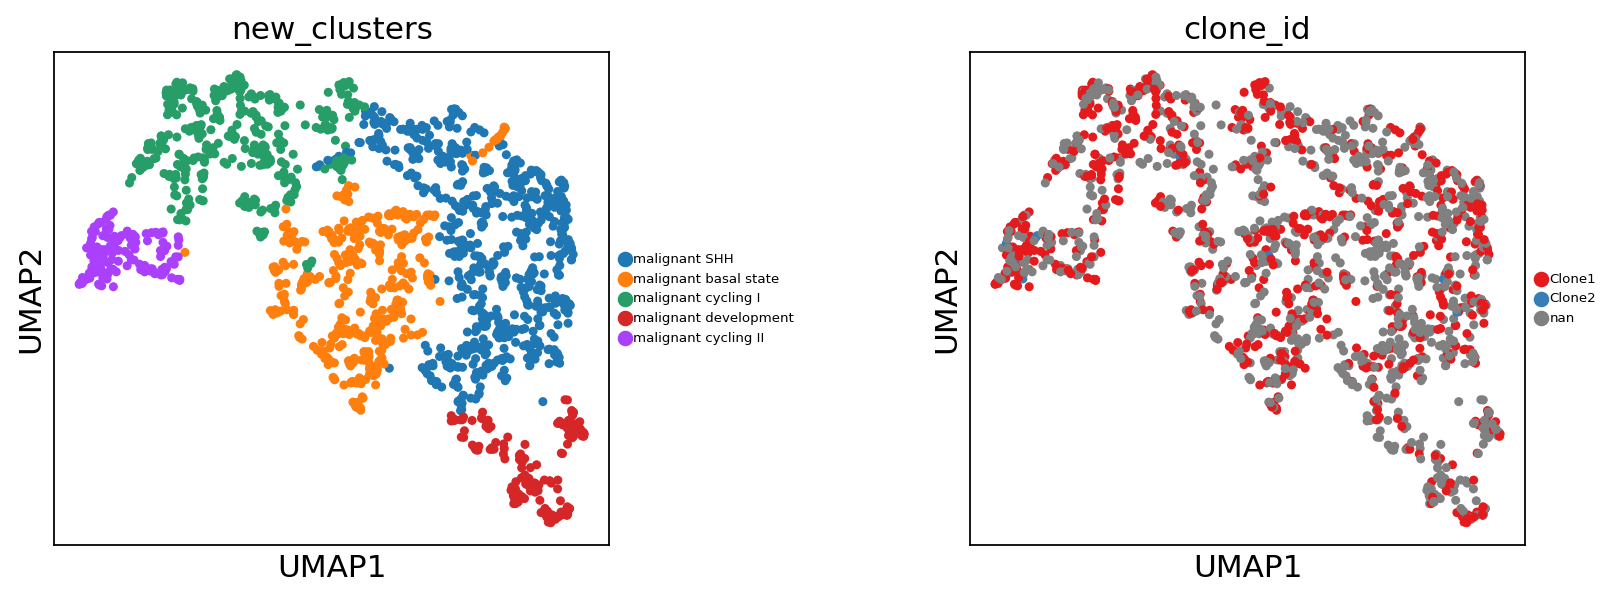

In [62]:
sc.pl.umap(adata, color=['new_clusters', 'clone_id'], save = '_ST1R-PDX_scDNA_clones_integrated.pdf', wspace = 0.5, legend_fontsize = 6)

In [ ]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/infercnv_MB/ST1R-PDX_metadata.csv')

In [ ]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(
            adata,
            groupby='clone_id',
            groups=['Clone1', 'Clone2'],
            reference='rest',
            use_raw=True,
            method='wilcoxon',
            n_genes=2000,
            corr_method='benjamini-hochberg'
        )
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges','scores', "pvals", 'pvals_adj']})

In [ ]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/ST1R-PDX_DEG_wilcoxon_integrated_scDNA_clones_only.csv")

In [ ]:
wilcoxon_df

## PROJECT CHROMOTHRIPSIS SIGNATURE ONTO THE EMBEDDING

In [10]:
f="/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/MB_shh_filtered_table_FDR.tsv"
pos_df=pd.read_table(f, sep='\t')
pos_df=pos_df.loc[pos_df['log2FoldChange'] > 0,:]
pos_df=pos_df.loc[pos_df['padj'] <= 0.05,:]
neg_df=pd.read_table(f, sep='\t')
neg_df=neg_df.loc[neg_df['log2FoldChange'] < 0,:]
neg_df=neg_df.loc[neg_df['padj'] <= 0.05,:]

In [11]:
pos_df
neg_df

,ens_fullid,ens_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
409,ENSG00000187097.12_3,ENSG00000187097,1662.242563,-0.359350,0.109875,-3.270523,1.073486e-03,0.036798,ENTPD5
410,ENSG00000250462.8_2,ENSG00000250462,1332.612360,-0.407023,0.128259,-3.173454,1.506366e-03,0.045176,LRRC37BP1
411,ENSG00000076242.14_2,ENSG00000076242,4657.937488,-0.414492,0.112141,-3.696177,2.188700e-04,0.013763,MLH1
412,ENSG00000113812.13_3,ENSG00000113812,6868.479447,-0.436607,0.127945,-3.412451,6.438160e-04,0.026346,ACTR8
413,ENSG00000100890.15_3,ENSG00000100890,808.125224,-0.443807,0.140809,-3.151842,1.622438e-03,0.047158,KIAA0391
...,...,...,...,...,...,...,...,...,...
1042,ENSG00000237869.2,ENSG00000237869,12.804303,-5.767545,1.786001,-3.229307,1.240907e-03,0.040182,RP11-459O16.1
1043,ENSG00000183072.9_2,ENSG00000183072,260.545238,-5.943601,1.123514,-5.290188,1.220000e-07,0.000112,NKX2-5
1044,ENSG00000266736.1_2,ENSG00000266736,102.835417,-6.129589,1.766502,-3.469902,5.206490e-04,0.023260,RP11-260A9.4
1045,ENSG00000253226.1_2,ENSG00000253226,23.377382,-6.273874,1.701660,-3.686913,2.269910e-04,0.014047,HAUS1P3


In [12]:
gene_list_pos=pos_df['gene_name']
intersect_gene_list_pos=adata.var_names.isin(list(gene_list_pos))
gene_list_pos=adata.var_names[intersect_gene_list_pos]

In [13]:
len(gene_list_pos)

46

In [14]:
gene_list_neg=neg_df['gene_name']
intersect_gene_list_neg=adata.var_names.isin(list(gene_list_neg))
gene_list_neg=adata.var_names[intersect_gene_list_neg]

In [15]:
len(gene_list_neg)

69

In [16]:
sc.tl.score_genes(adata, list(gene_list_pos), ctrl_size=len(gene_list_pos), gene_pool=None, n_bins=25, score_name='Upregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, list(gene_list_neg), ctrl_size=len(gene_list_neg), gene_pool=None, n_bins=25, score_name='Downregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)

computing score 'Upregulated_Chromothripsis_Score'
    finished: added
    'Upregulated_Chromothripsis_Score', score of gene set (adata.obs).
    952 total control genes are used. (0:00:00)
computing score 'Downregulated_Chromothripsis_Score'
    finished: added
    'Downregulated_Chromothripsis_Score', score of gene set (adata.obs).
    1476 total control genes are used. (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


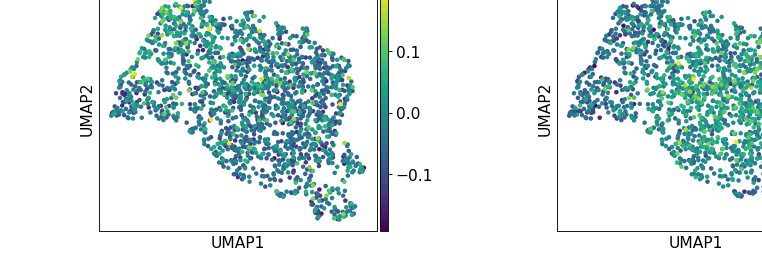

In [17]:
sc.pl.umap(adata, color=['Upregulated_Chromothripsis_Score', 'Downregulated_Chromothripsis_Score'], save = '_ST1R-PDX_chromothripsisScore.pdf', wspace = 0.5)

In [18]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/ST1R-PDX_chromothripsisScore_metadata.csv')

In [19]:
metadata

,sample,technology,patient,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,louvain,leiden,new_clusters,clone_id,min_pval,Upregulated_Chromothripsis_Score,Downregulated_Chromothripsis_Score
AAACCTGAGTACATGA-1,ST1R,PDX,ST,1309,1307,3161.0,137.0,4.334072,1031.0,32.616261,0,cluster1,malignant basal state,nan,NaN,-0.059438,-0.037533
AAACCTGCAAGCCCAC-1,ST1R,PDX,ST,1225,1220,3013.0,198.0,6.571523,1001.0,33.222702,1,cluster2,malignant cycling I,Clone1,0.001,0.017392,0.002323
AAACCTGCAGCCAATT-1,ST1R,PDX,ST,2197,2193,4993.0,357.0,7.150010,948.0,18.986582,0,cluster0,malignant SHH,nan,NaN,0.003822,-0.039611
AAACGGGAGCGAGAAA-1,ST1R,PDX,ST,1676,1673,3586.0,110.0,3.067485,631.0,17.596207,1,cluster2,malignant cycling I,nan,NaN,-0.038216,-0.048013
AAACGGGGTAAGGGAA-1,ST1R,PDX,ST,1098,1097,2126.0,83.0,3.904045,553.0,26.011288,0,cluster1,malignant basal state,Clone1,0.004,-0.000766,-0.034247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTTACGTCA-1,ST1R,PDX,ST,926,924,1521.0,52.0,3.418804,327.0,21.499014,0,cluster0,malignant SHH,nan,NaN,-0.037525,-0.069258
TTTGGTTTCAAACAAG-1,ST1R,PDX,ST,3281,3272,8823.0,255.0,2.890173,1602.0,18.157089,3,cluster4,malignant cycling II,Clone1,0.001,-0.042036,-0.109630
TTTGTCAAGTCCCACG-1,ST1R,PDX,ST,889,888,1467.0,54.0,3.680982,375.0,25.562372,2,cluster0,malignant SHH,nan,NaN,-0.027011,-0.055409
TTTGTCACAATGCCAT-1,ST1R,PDX,ST,1360,1358,3154.0,253.0,8.021560,954.0,30.247303,2,cluster1,malignant basal state,nan,NaN,0.041316,0.026560


In [20]:
data_crosstab = pd.crosstab(metadata['new_clusters'], metadata['clone_id'], margins = False)
print(data_crosstab)

clone_id               Clone1  Clone2  nan   
new_clusters                                 
malignant SHH             264       3     394
malignant basal state     194       1     236
malignant cycling I       222       2     190
malignant development      55       0     105
malignant cycling II       79       9      63


In [21]:
data_crosstab.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/ST1R-PDX_contingencyTable_celltypes_clones.csv')